# Домашняя работа: Обучаем собственную Seq2seq модель

#### Установим зависимости.

В конце вы получите сообщение "You must restart the runtime in order to use newly installed versions.". Нажмите кнопку "RESTART RUNTIME".

In [ ]:
# Установим зависимости
!pip install transformers==4.11.0 torch==1.10.2 torchtext==0.11.2 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.9/881.9 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 62.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.5 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=5de447d91ed6ce114e437100d0f497bc5ca104bf9ce8561c9b2031103270d41b
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116


## Данные

Будем использовать англоязычный [датасет PennTreebank](https://pytorch.org/text/stable/datasets.html#penntreebank), доступный во фреймворке `torchtext`. 

Для начала заглянем в датасет и посмотрим, что представляет из себя пример из датасета.

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
from torchtext.datasets import PennTreebank


# создадим итератор по данным, загрузив готовый датасет PennTreebank из torchtext, 
# причем для начала, только обучающую train подвыборку, используя аргумент split
train_iter = PennTreebank(split='train')
# определим небольшое число примеров для демонстрации
nsamples = 5
# создадим переменную для сохранения текста примеров в единый текст
# в дальнейшем мы его заиспользуем для проверки паайплайна предобработки текста
training_samples_example = ""


for line in train_iter:
    print(line)
    training_samples_example += line
    nsamples -= 1
    if nsamples == 0:
        break

5.10MB [00:00, 103MB/s]                    

 aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter 

 pierre <unk> N years old will join the board as a nonexecutive director nov. N 

 mr. <unk> is chairman of <unk> n.v. the dutch publishing group 

 rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate 

 a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported 



In [ ]:
# посмотрим, как выглядят эти примеры, соединенные в одну строку
training_samples_example

' aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter \n pierre <unk> N years old will join the board as a nonexecutive director nov. N \n mr. <unk> is chairman of <unk> n.v. the dutch publishing group \n rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate \n a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported \n'

В данном тюториале мы собиаремся решать задачу sequence-to-sequence -- задачу предсказания следующего токена по предыдущим, то есть фактически задачу языкового моделирования. Поэтому нам не понадобятся пайплайны предобработки меток классов -- у нас их попросту нет. Поэтому далее мы переходим к предобработке текстов датасета.

## Токенизация

Для построения словаря, нам необходимо определить токенизатор данных -- модель, которая будетразделять единый текст на токены -- наиболее популярные единицы языка. 

В данном тюториале будем использовать базовый токенизатор для английского языка из библиотеки  `torchtext`.

In [ ]:
from torchtext.data.utils import get_tokenizer


# загрузим базовый англоязычный basic_english токенизатор с помощью get_tokenizer
tokenizer = get_tokenizer('basic_english')
# определим небольшое число примеров для демонстрации
nsamples = 5

for line in train_iter:
    # получим из строки line токены с помощью tokenizer
    tokenized_line = tokenizer(line)
    # распечатаем полученную информацию
    print(f"ORIGINAL SAMPLE:\n{line}")
    print(f"TOKENIZED SAMPLE:\n{tokenized_line}")
    nsamples -= 1
    if nsamples == 0:
        break

ORIGINAL SAMPLE:
 the asbestos fiber <unk> is unusually <unk> once it enters the <unk> with even brief exposures to it causing symptoms that show up decades later researchers said 

TOKENIZED SAMPLE:
['the', 'asbestos', 'fiber', '<unk>', 'is', 'unusually', '<unk>', 'once', 'it', 'enters', 'the', '<unk>', 'with', 'even', 'brief', 'exposures', 'to', 'it', 'causing', 'symptoms', 'that', 'show', 'up', 'decades', 'later', 'researchers', 'said']
ORIGINAL SAMPLE:
 <unk> inc. the unit of new york-based <unk> corp. that makes kent cigarettes stopped using <unk> in its <unk> cigarette filters in N 

TOKENIZED SAMPLE:
['<unk>', 'inc', '.', 'the', 'unit', 'of', 'new', 'york-based', '<unk>', 'corp', '.', 'that', 'makes', 'kent', 'cigarettes', 'stopped', 'using', '<unk>', 'in', 'its', '<unk>', 'cigarette', 'filters', 'in', 'n']
ORIGINAL SAMPLE:
 although preliminary findings were reported more than a year ago the latest results appear in today 's new england journal of medicine a forum likely to bri

## Словарь

Теперь нам необходимо собрать словарь -- структуру данных, содержащую проиндексированные токены, которые мы сможем использовать для векторизации текстов -- представлении текстов в удобном машиночитаемом формате. Для сбора словаря, так как нас интересуют непосредственно те слова, которые есть в нашем датасете (но при этом, мы не можем использовать слова из тестовой подвыборки датасета при создлании словаря), то будем строить словарь на основе итерирования по токенам по обучающей выборки.

В данном тюториале мы попрбуем два разных способа создать словарь на основе итератора по текстам. Оба способа создадут **идентичные по содержащимся токенам словари**.

**Первый способ** заключается в использование `Counter` для сбора токенов и инициализации  `torchtext.vocab.Vocab` на основе собранного `Counter`.

In [ ]:
from collections import Counter
from torchtext.vocab import Vocab


# создадим итератор по данным, загрузив готовый датасет PennTreebank из torchtext, 
# причем для начала, только обучающую train подвыборку, используя аргумент split
train_iter = PennTreebank(split='train')
# создадим инстанс Counter
counter = Counter()

for line in train_iter:
    # итерируясь по данным, токенизируем текст в каждом примере в датасете
    tokens = tokenizer(line)
    # добавим полученные токены в наш counter с помощью метода update
    counter.update(tokens)

# теперь создадим Vocab на основе нашего counter
vocab = Vocab(counter)
# посомтрим на размер собранного словаря
print(f"Vocabulary size: {vocab.__len__()}")

Vocabulary size: 9922


**Второй способ** состоит в создании словаря напрямую через итератор данных без использования `Counter`. Для этого воспользуемся функций `torchtext.vocab.build_vocab_from_iterator`.

In [ ]:
from torchtext.vocab import build_vocab_from_iterator


def yield_tokens():
    # итерируясь по обучающему датасету
    for line in train_iter:
        # токенизируем line
        tokens = tokenizer(line)
        yield tokens


# создадим итератор по данным, загрузив готовый датасет PennTreebank из torchtext, 
# причем для начала, только обучающую train подвыборку, используя аргумент split
train_iter = PennTreebank(split='train')
# используем build_vocab_from_iterator для получения vocab на основе yield_tokens(),
# обязательно добавив специальный токен "<unk>" в аргумент-список специальных токенов specials
vocab = build_vocab_from_iterator(yield_tokens(), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>']) 
# посмотрим на размер собранного словаря
print(f"Vocabulary size: {vocab.__len__()}")

Vocabulary size: 9922


Как мы видим, словари имеют одинаковые размер. Оба способа создают идентичные по содержащимся токенам словари.

## Подготовим датасет

Для подготовки датасета к процессу обучения модели seq2seq, необходимо 
* токенизировать тексты, 
* перевести токены в индексы токенов в словаре,
* преобразовать результат в тензор.

In [ ]:
import torch


def data_process(raw_text_iter):
    # подготовим переменную для индексов токенов
    data = []
    # итерируемся по данным
    for item in raw_text_iter:
        # каждый пример в датасете -- текст
        # токенизируем полученный текст с помощью tokenizer
        tokens = tokenizer(item)
        # для каждого токена из полученных токенизатором
        # получаем индекс токена в словаре с помощью vocab
        # и получаем лист индексов токенов
        tokens_ids = vocab(tokens)
        # преобразуем полученный лист индексов токенов текста 
        # в torch.tensor с типом dtype=torch.long
        tensor_tokens_ids = torch.tensor(data=tokens_ids, dtype=torch.long)
        # добавим в список data полученный тензор, 
        # если наш сэмпл данных содержит непустые токены (такие примеры получаются,
        # когда изначальная строка содержала только символы новой строки)
        if len(tokens_ids) > 0:
            data += [tensor_tokens_ids]
    
    return torch.cat(data)

In [ ]:
# а теперь перепишем эту функцию, но компактнее записанную
# и использующую list comprehension вместо циклов for 
# (list comprehension работает быстрее)

def data_process(raw_text_iter):
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) 
            for item in raw_text_iter if len(item.strip()) > 0]
    return torch.cat(data)

In [ ]:
# создадим ТРИ итератора по данным, загрузив готовый датасет PennTreebank из torchtext
train_iter, val_iter, test_iter = PennTreebank()

# предобработаем данные обучающей выборки
train_processed_data = data_process(train_iter)
# предобработаем данные валидационной выборки
val_processed_data = data_process(val_iter)
# предобработаем данные тестовой выборки
test_processed_data = data_process(test_iter)

400kB [00:00, 62.9MB/s]                   
450kB [00:00, 59.1MB/s]                   


In [ ]:
train_processed_data[:100]

tensor([9892, 9893, 9894, 9896, 9897, 9898, 9902, 9903, 9904, 9905, 9906, 9908,
        9909, 9910, 9911, 9913, 9914, 9915, 9916, 9917, 9918, 9919, 9920, 9921,
        9187,    0,    2,   74,  395,   34, 2126,    1,  146,   20,    5, 9139,
         275,  410,    8,    2,   24,    8,    0,   14,  141,    3,    0,    2,
           8, 2506,    8,    1, 3070, 1595,   97, 7627,    0,    2,   74,  395,
           7,  339,  141,    3, 2466,  659, 2162,  956,   25,  524,    5, 9139,
         275,    3,   40,  303,  441, 3667,    5,  943,    3, 3137,  499,  263,
           4,  138, 6053, 4223, 5997,   32,  988,    5,  241,  762,    3, 1016,
        2778,  211,    5,   97])

In [ ]:
# какой полуичлся размер обучающей выборки в числе токенов
train_processed_data.shape

torch.Size([924412])

In [ ]:
# попробуем перевести индексы слов в словаре в токены с помощью метода lookup_tokens
vocab.lookup_tokens(train_processed_data[:20].tolist())

['aer',
 'banknote',
 'berlitz',
 'calloway',
 'centrust',
 'cluett',
 'fromstein',
 'gitano',
 'guterman',
 'hydro-quebec',
 'ipo',
 'kia',
 'memotec',
 'mlx',
 'nahb',
 'punts',
 'rake',
 'regatta',
 'rubens',
 'sim']

Воспользуемся отложенной ранее строкой `training_samples_example`, чтобы проверить работу словаря и токенизатора

In [ ]:
# перевести токены в индексы слов в словаре с помощью метода lookup_indices
training_sample_indices = vocab.lookup_indices(tokenizer(training_samples_example)[:20])
training_sample_indices

[9892,
 9893,
 9894,
 9896,
 9897,
 9898,
 9902,
 9903,
 9904,
 9905,
 9906,
 9908,
 9909,
 9910,
 9911,
 9913,
 9914,
 9915,
 9916,
 9917]

In [ ]:
# перевести индексы слов в словаре в токены с помощью метода lookup_tokens
vocab.lookup_tokens(training_sample_indices)

['aer',
 'banknote',
 'berlitz',
 'calloway',
 'centrust',
 'cluett',
 'fromstein',
 'gitano',
 'guterman',
 'hydro-quebec',
 'ipo',
 'kia',
 'memotec',
 'mlx',
 'nahb',
 'punts',
 'rake',
 'regatta',
 'rubens',
 'sim']

Определим доступный нам для вычисления девайс: `cpu` или `gpu`. Для более эффективного и быстрого обучения, рекомендуется использовать `cpu`.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Батчевание данных

Для задачи sequence-to-sequence также хочется использовать батчевание данных для обучения. Однако все примеры в данных обычно разной длины, что в некоторых задач, например, переводе текста или суммаризации, когда входная и целевая последовательности отличаются, приводит к тому, что для кжадого батча определяется собственная максимальная длина (либо длина самого длинного прмиера в батче, либо максимальная допустимая длина примера). В задаче языкового моделирования, а именно предсказания следующего токена последовательности, обычно используется другой способ батчевания данных -- все примеры батча склеиваются в единую последовательность, а затем разбиваются на батчи,а лишние элементы отбрасываются. Да, теряется связь между последовательными элементами, попавшивими в разные батчи, однако, это делает вычисления значительно эффективнее.

In [ ]:
def batchify(data, batch_size):
    # Разделим размер данных data.size(0) на batch_size частей,
    # чтобы получить целое число батчей
    nbatch = data.size(0) // batch_size
    # обрезаем все элементы, которые не помещаются в пространство nbatch * batch_size
    # используем метод narrow для dim=0, start=0 и length=nbatch * batch_size
    # https://pytorch.org/docs/stable/generated/torch.narrow.html?highlight=narrow#torch.narrow
    data = data.narrow(0, 0, nbatch * batch_size)
    # абсолютно аналогично работает следующая строка:
    # data = data[:nbatch * batch_size]
    
    # теперь разделим данные на столбцы по размеру батча, используя метод view
    data = data.view(batch_size, nbatch)
    # транспонируем данные, используя метод t()
    # https://pytorch.org/docs/stable/generated/torch.t.html?highlight=t#torch.t
    data = torch.t(data)
    # преобразуем наш тензор в непрерывный в памяти с помощью метода contiguous
    # https://pytorch.org/docs/stable/generated/torch.Tensor.contiguous.html?highlight=contiguous#torch.Tensor.contiguous
    data = torch.Tensor.contiguous(data)
    # перенесем данные на девайс и вернем их
    return data.to(device)


# определим размер батча на время обучения
batch_size = 20
# определим размер батч на время инференса
eval_batch_size = 10

# батчуем данные обучающей выборки с помощью нашей функции batchify
train_data = batchify(train_processed_data, batch_size)
# батчуем данные валидационной выборки с помощью нашей функции batchify
val_data = batchify(val_processed_data, eval_batch_size)
# батчуем данные тестовой выборки с помощью нашей функции batchify
test_data = batchify(test_processed_data, eval_batch_size)

In [ ]:
train_data[0]

tensor([9892,    4,   31,   16, 1925,  178,    3, 2295,    5,   42, 3412, 1611,
           1,  730, 3722, 5722, 2124, 1678,  796,  829], device='cuda:0')

In [ ]:
train_data.shape

torch.Size([46220, 20])

Теперь мы видим, что у нас есть последовательности данных, неудобные для использования - первая размерность очень большая. Необходимо сделать итерации по первой размерности.


Создадим функцию для получения определенного i-го батча данных.

При этом введем переменную, содержащую максимальную длину последовательности.

In [ ]:
bptt = 35


def get_batch(source, i):
    """
    Функция генерирует батч пар входная-выходная последовательности.
    Так как последовательности являются длинными, 
    то мы используем не только размер батча, но и data chunks.
    
    Returns:
    - data of dimension (bptt, batch_size)
    - targets of dimension (bptt * batch_size)
    """
    # определяем длину последовательности как минимум между bptt и
    # длиной всех данных
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i : i + seq_len]
    target = source[i + 1 : i + 1 + seq_len].reshape(-1)
    return data, target

In [ ]:
data, targets = get_batch(train_data, 1)
print(data.shape)
print(targets.shape)

torch.Size([35, 20])
torch.Size([700])


## Архитектура модели

Данный тюториал предназначен для обучения модели Трансформер с нуля на задаче языкового моделирования. 

Напомним, что задача языкового моделирования заключается в предсказании распеределения вероятностей заданного токена встретиться сразу после заданной последовательности токенов, то есть по сути, предсказании следующего токена в последовательности.

Для языкового моделирования можно использовать модели, состоящие только из энкодера (encoder-only), например модель BERT содержит только энкодер. 

Итак, будем использовать `torch.nn.TransformerEncoderLayer` и `torch.nn.TransformerEncoder` (который состоит из заданного количества `nn.TransformerEncoderLayer`) в качестве энкодера.

Для создания такой модели необходима следующая последовательность действий:
1. последовательность токенов (индексов токенов) передается в слой векторных представлений.
2. далее последовательность передается в слой позиционных векторных представлений (positional encoding layer), отвечающих за передачу информации о последовательности токенов.
3. Полученные векторные представления передаются в линейный слой, размерность которого соответствует размеру словаря. Данный слой предсказывает распределение вероятностей по словарю для следующего токена последовательности.

Важной особенностью модели Трансформер является использование masked self-attention, данный метод не позволяет модели смотреть вперед (обращать внимание на токены, которые идут после заданного). Для этого используется специальная маска -- матрица, зануляющая элементы, на которые нельзя обращать внимание.


На рисунке ниже представлена схема encoder-only модели. В качестве features  мы получаем скрытые векторные представления входной последовательности, которые пропускаются через линейный слой для получения распределения вероятностей по словарю для следующего токена. Причем таких Encoder block может быть расположено последовательно несколько штук.

<img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm">

## Позиционные векторные представления (Positional Encoding)

Для передачи модели информации о взаимном расположении токенов необходимо также добавить позиционные векторные представления. Позиционные векторные представленияимеют те же размерности, что и векторные представления токенов самих по себе, что позволяет суммировать их в дальнейшем. В оригианльной работе Attention is All You Need авторы исследуют разные варианты используемых функций для позиционных векторных представлений и приходят к выводу, что используемые функции не играют значительной роли. Наиболее распространенными вариантами являются периодические функции синуса и косинуса.


In [ ]:
import math
import torch
import torch.nn as nn


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # создадим слой dropout как инстанс nn.Dropout слоя, 
        # получающего на вход значение dropout
        self.dropout = nn.Dropout(p=dropout)
        # создадим переменную pe как нулевую матрицу torch.zeros размера (max_len x d_model)
        pe = torch.zeros((max_len, d_model))
        # создадим переменную position как вектор torch.arange типа torch.float размера max_len, 
        # содержащий последовательные значения от 0 до max_len-1
        position = torch.arange(0, max_len, dtype=torch.float)
        # вытянем position вдоль оси 1 с помощью метода unsqueeze
        position = torch.unsqueeze(position, 1)
        # создадим переменную div_term как вектор torch.arange типа torch.float размера d_model / 2, 
        # содержащий каждое 2-е последовательное значение от 0 до d_model-1   
        div_term = torch.arange(0, d_model, 2).float()
        # домножим каждое значение div_term на специальный коэффициент (-math.log(10000.0) / d_model)
        div_term = torch.exp(div_term * (-math.log(10000.0) / d_model))
        # итак позиционные эмбеддинги нечетных элементов представляют из себя
        # перемноженные position и div_term пропускают через sin
        # https://pytorch.org/docs/stable/generated/torch.sin.html
        pe[:, 0::2] = torch.sin(position * div_term)
        # итак позиционные эмбеддинги четных элементов представляют из себя
        # перемноженные position и div_term пропускают через cos
        # https://pytorch.org/docs/stable/generated/torch.cos.html
        pe[:, 1::2] = torch.cos(position * div_term)
        # вытянем pe вдоль оси 0 с помощью метода unsqueeze
        pe = torch.unsqueeze(pe, 0)
        # транспонируем ее с помощью метода transpose
        pe = pe.transpose(0, 1)
        # добавим pe переменную в буффер модуля
        # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
        self.register_buffer('pe', pe)

    def forward(self, x):
        # добавим в исходным веткорным представления pe соответствующего размера
        x = x + self.pe[:x.size(0), :]
        # пропустим также выход через слой dropout
        return self.dropout(x)

**Создадим саму архиектуру модели, использующую наши позиционные векторные представления**.

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer


class TransformerModel(nn.Module):

    def __init__(self, vocab_size, emb_size, n_heads, hidden_dim, n_blocks, dropout=0.5):
        super(TransformerModel, self).__init__()
        # сохраним в атрибуты класса размер векторных представлений, 
        # чтобы он был доступен во всех методах класса
        self.emb_size = emb_size
        
        # зададим тип модели как 'Transformer'
        self.model_type = 'Transformer'
        
        # создадим слой pos_encoder как инстанс класса PositionalEncoding, 
        # принимающий на вход размер векторных представлений и дропаут
        self.pos_encoder = PositionalEncoding(d_model=self.emb_size, dropout=dropout)
        
        # создадим слой encoder_layers как инстанс слоя TransformerEncoderLayer, 
        # принимающий на вход размер векторных представлений, число голов, 
        # размер скрытого пространства и дропаут
        # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html
        encoder_layers = TransformerEncoderLayer(d_model=self.emb_size,
                                                 nhead=n_heads,
                                                 dim_feedforward=hidden_dim,
                                                 dropout=dropout)
        
        # создадим слой transformer_encoder как инстанс слоя TransformerEncoder, 
        # принимающий на вход на инстанс encoder_layers и желаемое число блоков энкодера
        # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
        self.transformer_encoder = TransformerEncoder(encoder_layer=encoder_layers,
                                                      num_layers=n_blocks)
        
        # создадим слой encoder как инстанс слоя nn.Embedding, 
        # принимающий на вход размер словаря и размер векторных представлений
        # https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.encoder = nn.Embedding(num_embeddings=vocab_size, 
                                    embedding_dim=self.emb_size)
        
        # создадим слой decoder как инстанс слоя nn.Linear, 
        # который преобразует вектора размерности векторных представлений в размер словаря
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.decoder = nn.Linear(in_features=self.emb_size,
                                 out_features=vocab_size)
        
        # инциализируем веса нашей модели с помощью нашего метода init_weights
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        """
        Данный метод создает квадратную маску размера (sz x sz) для self-attention.
        """
        # создадим единичную матрицу torch.ones размера (sz x sz)
        mask = torch.ones(sz, sz)
        # превратим ее в верхнетреугольную матрицу с помощью torch.triu 
        # (элементы на диалогнали и выше диалогнали -- единицы, остальные -- нули)
        mask = torch.triu(mask)
        # транспонируем ее с помощью метода transpose
        mask = mask.transpose(0, 1)
        
        # заменим значения, равные нулю, на -inf
        mask = mask.masked_fill(mask == 0, float('-inf'))
        # заменим значения, равные единице, на 0.0
        mask = mask.masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        # инициализируем веса энкодера случайными величинами 
        # из равномерного распределения в диапазоне (-initrange, initrange) 
        self.encoder.weight.data.uniform_(-initrange, initrange)
        # зададим в качестве начальных нулевые bias 
        self.decoder.bias.data.zero_()
        # инициализируем веса декодера (линейного слоя) случайными величинами 
        # из равномерного распределения в диапазоне (-initrange, initrange) 
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        # входная последовательность обрабатывается с помощью encoder
        src = self.encoder(src)
        # полученная последовательность домножается на квадратный корень 
        # из размера векторных представлений
        src = src * math.sqrt(self.emb_size)
        # полученная последовательность обрабатывается с помощью pos_encoder        
        src = self.pos_encoder(src)
        # полученная последовательность обрабатывается с помощью transformer_encoder,
        # который также принимает на вход маску для self-attention
        output = self.transformer_encoder(src, src_mask)
        # полученная последовательность обрабатывается с помощью decoder 
        output = self.decoder(output)
        return output

## Инициализация модели

Теперь мы можем инициалировать класс модели. Выберем размер векторных представлений 200, но вы можете изменить на больший размер.

In [ ]:
# размер словаря
vocab_size = vocab.__len__()
# размер векторных представлений
emb_size = 200
# размерность скрытого полносвязного слоя в nn.TransformerEncoder
hidden_dim = 200 
# число nn.TransformerEncoderLayer слоев в nn.TransformerEncoder
n_blocks = 2
# число голов  в  multiheadattention 
n_heads = 2
# величина dropout
dropout = 0.2

# инициализируем нашу модель класса TransformerModel,
# передав в качестве аргументов:
# размер словаря
# размер векторных представлений
# число голов  в  multiheadattention 
# размерность скрытого полносвязного слоя в nn.TransformerEncoder
# число  nn.TransformerEncoderLayer слоев в nn.TransformerEncoder
# величину dropout
model = TransformerModel(vocab_size, emb_size, n_heads, hidden_dim, n_blocks, dropout)
# перенесем модель на девайс
model.to(device)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=200, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=200, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        

# Обучение модели


В качестве лосса используем CrossEntropyLoss, в качестве оптимайзера -- Stochastic Gradient Descent (SGD).

In [ ]:
from torch.nn.modules.loss import CrossEntropyLoss
import time


LOG_INTERVAL = 500
EPOCHS = 3 # epoch
LR = 5  # learning rate - lr
# определим функцию потерь torch.nn.CrossEntropyLoss
criterion = CrossEntropyLoss()
# определим оптимизатор torch.optim.SGD с заданным lr, 
# передав также параметры модели model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# определим расписание изменения значения lr torch.optim.lr_scheduler.StepLR
# передав в качестве аргументов optimizer, 
# значение step_size равное 1, и значение gamma 0.95 (коэффициент убывания)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                            step_size=1, gamma=0.95)


def train():
    # создадим переменную для сохранения лоссов на обучающей выборке
    train_losses = []
    # обязательно переводим модель в режим обучения с помощью метода train()
    model.train()
    total_loss = 0.
    start_time = time.time()
    # используем метод модели generate_square_subsequent_mask для генерации маски,
    # передавая в качестве аргумента bptt, а также перенесем результат на девайс
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    # итерируемся батчами по заданному датасету
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        # получаем данные для батча под номером i
        data, targets = get_batch(train_data, i)
        # обнуляем градиенты с помощью метода zero_grad
        optimizer.zero_grad()
        
        if data.size(0) != bptt:
            # используем метод модели generate_square_subsequent_mask для генерации маски,
            # передавая в качестве аргумента bptt, а также перенесем результат на девайс
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            
        # передаем в модель data и src_mask
        output = model(data, src_mask)
        # получим распределение logits по выходным токенам 
        output_tokens = output.view(-1, vocab_size)
        # подсчитываем лосс с помощью criterion, 
        # вычисляемого на основе output_tokens и targets 
        # (напоминаю, targets -- это те же токены, сдвинутые на 1 вперед)
        loss = criterion(output_tokens, targets)
        # обратное распространение ошибки с помощью метода backward()
        loss.backward()
        # ограничиваем норму градиентов с помощью метода 
        # torch.nn.utils.clip_grad_norm_, в который передаются 
        # параметры модели model.parameters() и макс. значение нормы 0.5
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        # делаем шаг оптимизатора, то есть обновляем веса модели, 
        # с помощью метода step()
        optimizer.step()

        total_loss += loss.item()
        # добавим текущее значение лосса на батче обучающей выборки в наш лист
        # train_losses, который потом будем использовать для печати лоссов
        train_losses += [loss.item()]
        
        # теперь проверяем, не настоли ли время логгирования скоров на обучающей выборке
        if batch % LOG_INTERVAL == 0 and batch > 0:
            cur_loss = total_loss / LOG_INTERVAL
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_last_lr()[0],
                    elapsed * 1000 / LOG_INTERVAL,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
            
    return train_losses


def evaluate(eval_model, data_source):
    # обязательно переводим модель в режим инференса (эвалюации) 
    # с помощью метода eval()
    eval_model.eval() 
    
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    
    # эвалюация не должна обновлять градиенты модели
    with torch.no_grad():
          # итерируемся батчами по заданному датасету
        for i in range(0, data_source.size(0) - 1, bptt):
            # получаем данные для батча под номером i
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                # используем метод модели generate_square_subsequent_mask для генерации маски,
                # передавая в качестве аргумента bptt, а также перенесем результат на девайс
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            # передаем в модель data и src_mask
            output = model(data, src_mask)
            # получим распределение logits по выходным токенам 
            output_flat = output.view(-1, vocab_size)
            # подсчитываем лосс с помощью criterion, 
            # вычисляемого на основе output_tokens и targets 
            # (напоминаю, targets -- это те же токены, сдвинутые на 1 вперед)
            valid_loss = criterion(output_flat, targets).item()
            total_loss += len(data) * valid_loss
    
    return total_loss / (len(data_source) - 1)

Запускаем тренировку и смотрим, как падает лосс.

In [ ]:
best_val_loss = float("inf")
best_model = None

# зададим переменные для сохранения хначения лоссов
# для дальнейшего построения графиков
train_losses = []
eval_losses = []

# подсчитаем значения лосса на валидационной выборке до начала обучения с помощью нашей функции evaluate
val_loss = evaluate(model, val_data)
# сохраним первое значение лосса на валидационной подвыборке
eval_losses += [val_loss]


for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    # запускаем обучения на 1 эпоху с помощью нашей функции train
    train_losses += train()
    # подсчитываем качество на валидационной подвыборке 
    # с помощью нашей функции evaluate
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)
    eval_losses += [val_loss]

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
    
    scheduler.step()

| epoch   1 |   500/ 1320 batches | lr 5.00 | ms/batch  7.38 | loss  6.50 | ppl   666.79
| epoch   1 |  1000/ 1320 batches | lr 5.00 | ms/batch  8.03 | loss  5.66 | ppl   288.04
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 11.06s | valid loss  5.47 | valid ppl   238.58
-----------------------------------------------------------------------------------------
| epoch   2 |   500/ 1320 batches | lr 4.75 | ms/batch  9.94 | loss  5.37 | ppl   214.75
| epoch   2 |  1000/ 1320 batches | lr 4.75 | ms/batch 12.07 | loss  5.27 | ppl   194.88
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 13.73s | valid loss  5.33 | valid ppl   206.74
-----------------------------------------------------------------------------------------
| epoch   3 |   500/ 1320 batches | lr 4.51 | ms/batch  7.31 | loss  5.15 | ppl   172.76
| epoch   3 |  1000/ 1320 batches | lr 4.51 | m

In [ ]:
len(train_losses), len(eval_losses), len(train_losses) / EPOCHS

(3963, 4, 1321.0)

## Построим графики loss значений

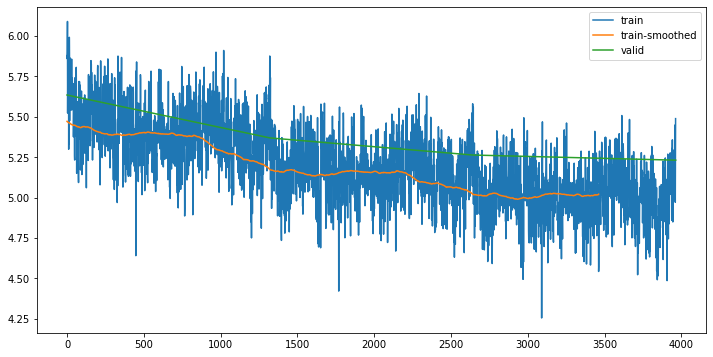

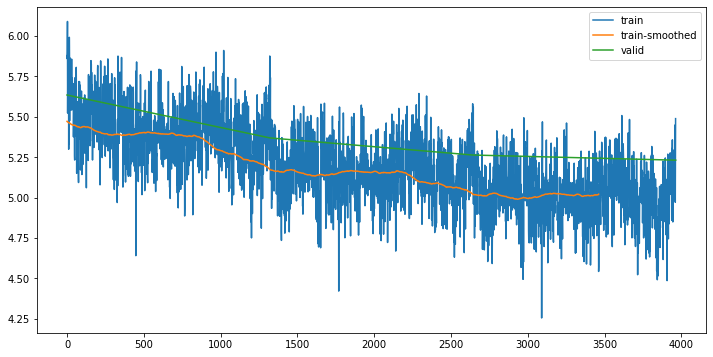

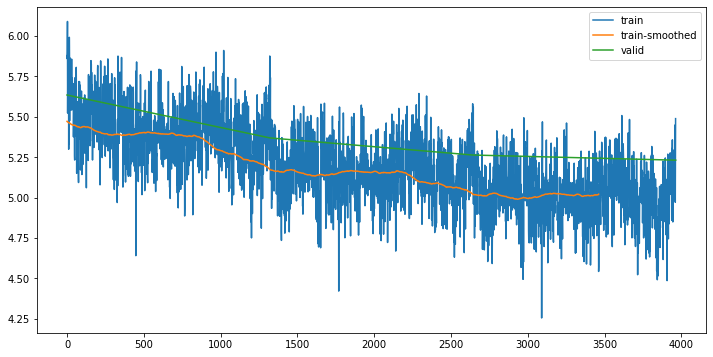

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


# так как в train_losses хранятся лоссы с каждого батча, то их слишком много 
# для качественной и наглядной визуализации. 
# Построим также сглаженное значение train_losses c заданным SMOOTHING_PERIOD
SMOOTHING_PERIOD = 500

plt.figure(figsize=[12, 6])
# строим полученные лоссы с каждого батча обучения
plt.plot(train_losses, label="train")

# получим сглаженные значения train_losses
smoothed = np.convolve(train_losses, np.ones(SMOOTHING_PERIOD)/SMOOTHING_PERIOD)
# строим сглаженные лоссы обучения
plt.plot(smoothed[SMOOTHING_PERIOD:-SMOOTHING_PERIOD], label="train-smoothed")

# строим полученные лоссы с каждой эвалюации
plt.plot(len(train_losses) / EPOCHS * np.arange(EPOCHS + 1), eval_losses, label="valid")

# добавим легенду для интерпретируемости
plt.legend()
plt.show()